# NYC Public High School SAT Score Analysis

## Background Information

1.New York City is divided into 5 boroughs, which are essentially distinct regions.

2.Schools in New York City are divided into several school district, each of which can contains dozens of schools.

3.Not all the schools in all of the datasets are high schools, so we’ll need to do some data cleaning.

4.Each school in New York City has a unique code called a DBN, or District Borough Number.

5.By aggregating data by district, we can use the district mapping data to plot district-by-district differences.


## Data

1.2010 ap test resut

2.2010-11 class size

3.2006-12 demographic

4.2005-10 graduation outcomes

5.2010-11 School Attendance and Enrollment Statistics by District (hs_directory.csv)

6.2006-10 Math Result

7.2012 SAT Score Result

8.school district map

In [1]:
import pandas
import numpy as np

files = ["2010 ap.csv", "2010-11 class_size.csv", "2006-12 demographics.csv", "2003-06 Graduation_Outcomes.csv", "2010-11 hs_directory.csv", "2006-10 math_test_results.csv", "2012 sat_results.csv"]

data = {}
for f in files:
    d = pandas.read_csv("Data/{0}".format(f))
    data[f.replace(".csv", "")] = d
    
data["ap"] = data.pop("2010 ap")
data["class_size"] = data.pop("2010-11 class_size")
data["demographics"] = data.pop("2006-12 demographics")
data["graduation"] = data.pop("2003-06 Graduation_Outcomes")
data["hs_directory"] = data.pop("2010-11 hs_directory")
data['math_test_results'] = data.pop("2006-10 math_test_results")
data["sat_results"] = data.pop("2012 sat_results")

#Input Survey data
survey1 = pandas.read_csv("Data/2011 survey data/masterfile11_gened_final.txt", delimiter="\t", encoding='windows-1252')
survey2 = pandas.read_csv("Data/2011 survey data/masterfile11_d75_final.txt", delimiter="\t", encoding='windows-1252')
survey1["d75"] = False
survey2["d75"] = True
survey = pandas.concat([survey1, survey2], axis=0)

survey["DBN"] = survey["dbn"]
survey_fields = ["DBN", "rr_s", "rr_t", "rr_p", "N_s", "N_t", "N_p", "saf_p_11", "com_p_11", "eng_p_11", "aca_p_11", "saf_t_11", "com_t_11", "eng_t_10", "aca_t_11", "saf_s_11", "com_s_11", "eng_s_11", "aca_s_11", "saf_tot_11", "com_tot_11", "eng_tot_11", "aca_tot_11",]
survey = survey.loc[:,survey_fields]
data["survey"] = survey
survey.shape

(1702, 23)

In [2]:
for k,v in data.items():
    print("\n" + k + "\n")
    print(v.head())


math_test_results

      DBN Grade  Year      Category  Number Tested Mean Scale Score Level 1 #  \
0  01M015     3  2006  All Students             39              667         2   
1  01M015     3  2007  All Students             31              672         2   
2  01M015     3  2008  All Students             37              668         0   
3  01M015     3  2009  All Students             33              668         0   
4  01M015     3  2010  All Students             26              677         6   

  Level 1 % Level 2 # Level 2 % Level 3 # Level 3 % Level 4 # Level 4 %  \
0      5.1%        11     28.2%        20     51.3%         6     15.4%   
1      6.5%         3      9.7%        22       71%         4     12.9%   
2        0%         6     16.2%        29     78.4%         2      5.4%   
3        0%         4     12.1%        28     84.8%         1        3%   
4     23.1%        12     46.2%         6     23.1%         2      7.7%   

  Level 3+4 # Level 3+4 %  
0          26 

In [3]:
data["hs_directory"].columns

Index([u'dbn', u'school_name', u'boro', u'building_code', u'phone_number',
       u'fax_number', u'grade_span_min', u'grade_span_max',
       u'expgrade_span_min', u'expgrade_span_max', u'bus', u'subway',
       u'primary_address_line_1', u'city', u'state_code', u'zip', u'website',
       u'total_students', u'campus_name', u'school_type',
       u'overview_paragraph', u'program_highlights', u'language_classes',
       u'advancedplacement_courses', u'online_ap_courses',
       u'online_language_courses', u'extracurricular_activities',
       u'psal_sports_boys', u'psal_sports_girls', u'psal_sports_coed',
       u'school_sports', u'partner_cbo', u'partner_hospital',
       u'partner_highered', u'partner_cultural', u'partner_nonprofit',
       u'partner_corporate', u'partner_financial', u'partner_other',
       u'addtl_info1', u'addtl_info2', u'start_time', u'end_time',
       u'se_services', u'ell_programs', u'school_accessibility_description',
       u'number_programs', u'priority01', u

# Unify the Data

In [4]:
#class_size Data sets hasn't the uniform shcool code. Need to clean the feature
data["class_size"]["DBN"] = data["class_size"].apply(lambda x: "{0:02d}{1}".format(x["CSD"], x["SCHOOL CODE"]), axis=1)
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]


# Condense Data 

In [5]:
##########################################################################
##############For Each dataset, using most recent year data###############
##########################################################################

#Group class size based on school code(DBN)

class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]
class_size = class_size.groupby("DBN").agg(np.mean)

#Put DBN back to columns instead of index
class_size.reset_index(inplace=True)
data["class_size"] = class_size

#Collect most recent Data
demographics = data["demographics"]
demographics = demographics[demographics["schoolyear"] == 20112012]
data["demographics"] = demographics

#Filter Function
def mask(df, key, value):
    return df[df[key] == value]
pandas.DataFrame.mask = mask

data["math_test_results"] = (data["math_test_results"].mask("Year",2011)).mask("Grade","8")
data["graduation"] = data["graduation"].mask("Demographic","Total Cohort").mask("Cohort","2006")

data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]
data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]

#Calculate Total SAT score
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = data["sat_results"][c].convert_objects(convert_numeric=True)
data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

#Clean GeoJso data,convert str geojson data to numeric lat/lon
data["hs_directory"]['lat'] = data["hs_directory"]['Location 1'].apply(lambda x: x.split("\n")[-1].replace("(", "").replace(")", "").split(", ")[0])
data["hs_directory"]['lon'] = data["hs_directory"]['Location 1'].apply(lambda x: x.split("\n")[-1].replace("(", "").replace(")", "").split(", ")[1])

for c in ['lat', 'lon']:
    data["hs_directory"][c] = data["hs_directory"][c].convert_objects(convert_numeric=True)

/home/dawei/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:35: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
/home/dawei/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:43: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.


In [6]:
for k,v in data.items():
    print("\n" + k + "\n")
    print(v.head())


math_test_results

        DBN Grade  Year      Category  Number Tested Mean Scale Score  \
111  01M034     8  2011  All Students             48              646   
280  01M140     8  2011  All Students             61              665   
346  01M184     8  2011  All Students             49              727   
388  01M188     8  2011  All Students             49              658   
411  01M292     8  2011  All Students             49              650   

    Level 1 # Level 1 % Level 2 # Level 2 % Level 3 # Level 3 % Level 4 #  \
111        15     31.3%        22     45.8%        11     22.9%         0   
280         1      1.6%        43     70.5%        17     27.9%         0   
346         0        0%         0        0%         5     10.2%        44   
388        10     20.4%        26     53.1%        10     20.4%         3   
411        15     30.6%        25       51%         7     14.3%         2   

    Level 4 % Level 3+4 # Level 3+4 %  
111        0%          11       22.9% 

# Combining the datasets

In [7]:
flat_data_names = [k for k,v in data.items()]
flat_data = [data[k] for k in flat_data_names]
full = flat_data[0]
for i, f in enumerate(flat_data[1:]):
    name = flat_data_names[i+1]
    print(name)
    print(len(f["DBN"]) - len(f["DBN"].unique()))
    join_type = "inner"
    if name in ["sat_results", "ap_2010", "graduation"]:
        join_type = "outer"
    if name not in ["math_test_results"]:
        full = full.merge(f, on="DBN", how=join_type)

#Clean Nan value
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    full[col] = full[col].convert_objects(convert_numeric=True)

full[cols] = full[cols].fillna(value=0)
full = full.fillna(full.mean())

#First Two Dight of DBN is District Number
full["school_dist"] = full["DBN"].apply(lambda x: x[:2])



sat_results
0
demographics
0
graduation
0
hs_directory
0
ap
1
survey
0
class_size
0


/home/dawei/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:18: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.


# School Location Clustering

In [8]:
######################################################################
####################School Location Clustering########################

import folium
from folium import plugins

schools_map = folium.Map(location=[full['lat'].mean(), full['lon'].mean()], zoom_start=10)
marker_cluster = folium.MarkerCluster().add_to(schools_map)
for name, row in full.iterrows():
    folium.Marker([row["lat"], row["lon"]], popup="{0}: {1}".format(row["DBN"], row["school_name"])).add_to(marker_cluster)
schools_map.create_map('schools.html')
schools_map



/home/dawei/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:11: FutureWarning: Map.create_map is deprecated. Use Map.save instead


In [9]:
schools_heatmap = folium.Map(location=[full['lat'].mean(), full['lon'].mean()], zoom_start=10)
schools_heatmap.add_children(plugins.HeatMap([[row["lat"], row["lon"]] for name, row in full.iterrows()]))
schools_heatmap.save("heatmap.html")
schools_heatmap

In [11]:
###################################################################
########################District Map###############################
###################################################################
district_data = full.groupby("school_dist").agg(np.mean)
district_data.reset_index(inplace=True)
district_data["school_dist"] = district_data["school_dist"].apply(lambda x: str(int(x)))

def show_district_map(col):
    geo_path = 'Data/School Districts.geojson'
    districts = folium.Map(location=[full['lat'].mean(), full['lon'].mean()], zoom_start=10)
    districts.choropleth(
        geo_path=geo_path,
        data=district_data,
        columns=['school_dist', col],
        key_on='features.properties.school_dist',
        fill_color='YlGn',
        fill_opacity=0.7,
        line_opacity=0.2,
    )
    
    districts.save("districts.html")
    return districts
    #return districts

show_district_map("sat_score")

/home/dawei/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:18: FutureWarning: 'threshold_scale' default behavior has changed. Now you get a linear scale between the 'min' and the 'max' of your data. To get former behavior, use folium.utilities.split_six.


AttributeError: 'NoneType' object has no attribute 'get'

In [ ]:
district_data["school_dist"].unique()

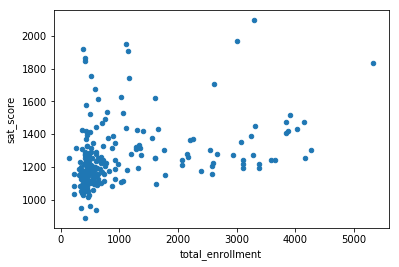

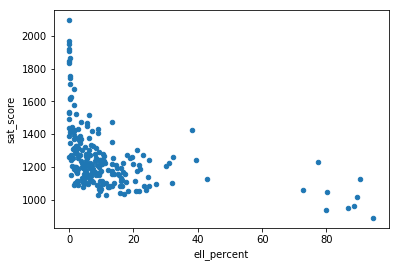

In [13]:
%matplotlib inline

full.plot.scatter(x='total_enrollment', y='sat_score')
full.plot.scatter(x='ell_percent', y='sat_score')


In [ ]:
import numpy as np
import pandas as pd
import datetime
import urllib
 
from bokeh.plotting import *
from bokeh.models import HoverTool
from collections import OrderedDict

query = ("https://data.cityofnewyork.us/resource/cuae-wd7h.json")
raw_data = pd.read_json(query)	


In [ ]:
raw_data

In [ ]:
data["math_test_results"][data["math_test_results"]["Year"] == 2011]